# Coding Exercise 4: Job Search with Separation and Stochastic Offers

## Question 1: Discrete and IID Wage Offers



### The model

An unemployed worker receives with a probability $0 < \gamma < 1$ a wage offer $ w_t $, where $ \{w_t\} $ is IID and is drawn from a publicly known probability distribution $ q(w) $ from a set finite set $\mathbb{W} $ at each point in time.

Once receiving an offer at time $ t $, the unemployed worker has two options:

1. Accept the offer and work at constant wage $ w_t $ until she gets laid off.  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.  

Each period an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. 

The agent is infinitely lived and aims to maximize the expected discounted sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

where 
- $ \beta \in (0, 1) $ is the discount factor.
- $ y_t $ is income, equal to
    - his/her wage $ w_t $ when employed  
    - unemployment compensation $ c $ when unemployed  

Let's denote $ V(w) $ and $ U $ the value of being employed at wage $w$ and the value of being unemployed, respectively. Then 

<a id='value_V'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha)V(w) + \alpha U \Big] \tag{1}
$$

and

<a id='value_U'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma \sum_{w' \in \mathbb W} \max\left\{V(w'), U\right\} q(w') \right] \tag{2}
$$


### Q.1-0: Import all external libraries that will used below.
    
- `numpy`, `numba`, `matplotlib` as usual
- `binom` from scipy.stats to generate wage offer distribution function in Q.1
- `brentq` from quantecon.optimize to solve the reservation wage in Q.2 

In [1]:
pip install quantecon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 8.5 MB/s eta 0:00:00


In [2]:
# your code here

import numpy as np
import matplotlib.pyplot as plt
from quantecon.optimize import brentq
from scipy.stats import binom, norm
from numba import njit, prange, float64
from numba.experimental import jitclass

### Q.1-1: Generate wage offer distribution

Suppose that the wage offers from a binomial distribution $B(n,p)$ with $n=50$ and $p=0.5$. Also assume that the set of possible wage offers has $n+1$ elements with the lowest wage is 10 and the highest wage is 40.

- Generate a vector `w` for wage offers and `q` for the probability for each wage offer. 
- plot `q` against `w`.

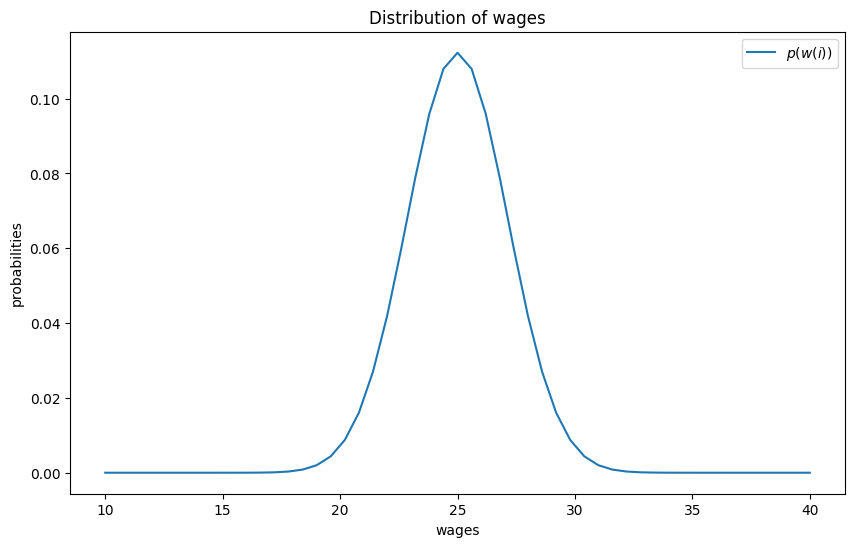

In [3]:
# your code here


n = 50
p = 0.5
w_default = np.linspace(10, 40, num=n+1)
dist = binom(n, p)
q_default = np.array([dist.pmf(i) for i in range(n+1)])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(w_default, q_default, label='$p(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
ax.set_title('Distribution of wages')
ax.legend()
plt.show()

### Q.1-2: Define the Class for the Model Economy

- specify types of the variables that are used in the class in `mccall_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (1) and (2) 
- jit-compile the class with `@jitclass`


In [4]:
# your code here

mccall_data = [
    ('alpha', float64),
    ('beta', float64),
    ('gamma', float64),
    ('sigma', float64),
    ('c', float64),
    ('w', float64[:]),
    ('q', float64[:])]

@jitclass(mccall_data)
class McCallModel:

    def __init__(self, alpha=0.1, beta=0.98, gamma=0.7, sigma=2.0, c=6.0, w=w_default, q=q_default):
        self.alpha, self.beta, self.gamma, self.sigma, self.c, self.w, self.q = alpha, beta, gamma, sigma, c, w, q

    def u(self, x):
        return (x ** (1 - self.sigma) - 1) / (1 - self.sigma)
    
    def update(self, V, U):
        alpha, beta, gamma, sigma, c, w, q = self.alpha, self.beta, self.gamma, self.sigma, self.c, self.w, self.q
        u = self.u

        V_new = np.empty_like(V)
        U_new = np.empty_like(U)

        for i in range(len(w)):
            V_new[i] = u(w[i]) + beta * ((1 - alpha) * V[i] + alpha * U)

        U_new = u(c) + beta * ((1 - gamma) * U + gamma * np.sum(np.maximum(V, U) * q))

        return V_new, U_new

### Q.1-3: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`
- Create an instance `mcm` of the class `McCallModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


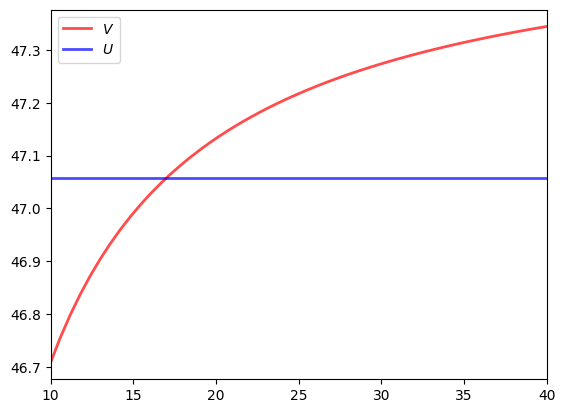

In [5]:
# your code here

@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):

    V = np.ones_like(mcm.w)
    U = 1
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        V_new, U_new = mcm.update(V, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V = V_new
        U = U_new
        i += 1

    return V, U

mcm = McCallModel()
V, U = solve_model(mcm)

fig, ax = plt.subplots()

ax.plot(mcm.w, V, 'red', lw=2, alpha=0.7, label='$V$')
ax.plot(mcm.w, [U] * len(mcm.w), 'blue', lw=2, alpha=0.7, label='$U$')
ax.set_xlim(min(mcm.w), max(mcm.w))
ax.legend()

plt.show()

### Q.1-4: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage. 

In [6]:
# your code here

@njit
def compute_reservation_wage(mcm):

    V, U = solve_model(mcm)
    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if V[i] > U:
            w_bar = wage
            break

    return w_bar

reservation_wage = compute_reservation_wage(mcm)
reservation_wage

17.2

### Q.1-5: Unemployment Rate in the Steady State

The steady state of the labor market in the model economy is the situation where flows between employment and unemployment are equal. Assuming the size of labor force being one, the inflow to unemployment is $\alpha (1-u)$ and outflow from unemployment is $f u$, where $f = \sum_{q\ge \bar w} q(w)$ is the job finding rate for an unemployed worker. Hence the unemployment rate in the steady state is:
$$
u^* = \frac{\alpha}{\alpha + f}
$$

- write a function `steady_state_unemployment` to compute the unemployment rate in the steady state.
- jit compile the function with `@njit`
- execute the function to show the the unemployment rate in the steady state.

In [7]:
# your code here

@njit
def steady_state_unemployment(mcm):

    w_bar = compute_reservation_wage(mcm)
    f = 0
    for i in range(len(mcm.q)):
        if mcm.w[i] >= w_bar:
            f += mcm.q[i]
    u_star = mcm.alpha / (mcm.alpha + f)

    return u_star

Steady_state_unemployment = steady_state_unemployment(mcm)
Steady_state_unemployment

0.09091281895043991

### Q.1-6: Average Unemployment Duration

- write a function `compute_average_unemployment_duration` to compute the average unemployment duration of 10,000 unemployed workers.
- the functioin should include functions `compute_stopping_time` to compute the unemployment duration of an unemployed worker and `compute_mean_stopping_time(num_reps=10000)` to simulate 10,000 unemployed workers.
- jit compile the inside functions with `@njit` and `@njit(parallel=True)`.
- execute the function to show the the average unemployment duration.


In [47]:
# your code here

def compute_average_unemployment_duration(mcm, seed=42):

    res_wage = compute_reservation_wage(mcm)
    np.random.seed(seed)

    # 10_000 x 10_000 짜리 wage를 distribution에서 뽑아 wage matrix를 만듦
    w = np.random.choice(mcm.w, size=(10_000, 10_000), p=mcm.q)

    @njit
    def compute_stopping_time(t_max=10_000):

        t = 0
        
        # 개인 index를 0부터 9_999까지 중에 뽑아서 wage matrix에서 low를 지정함, 그 low가 10_000기 동안 주어질 임금의 vector임
        idx = np.random.randint(0, 10_000)
        unemployed = True

        while unemployed and t < t_max:
            if w[idx][t] >= res_wage:
                unemployed = False
                t_star = t
            else:
                t += 1
        return t_star

    @njit(parallel=True)
    def compute_mean_stopping_time(num_reps=10_000):
        sum_value = 0
        for i in prange(num_reps):
            sum_value += compute_stopping_time()
        return sum_value / num_reps

    return compute_mean_stopping_time()

average_unemployment_duration = compute_average_unemployment_duration(mcm)
average_unemployment_duration

0.0003

In [48]:
# binomial distribution은 tail이 작기 때문에 reservation wage보다 작은 wage가 나올 확률이 너무 작아서 duration이 0에 가까움

using the above codes that you wrote, compute the reservation wage, steady state unemployment rate, average unemployment duration for the model.

In [49]:
print('reservation wage is ', reservation_wage)
print('steady state unemploy rate is ', Steady_state_unemployment)
print('average unemployment duration is ', average_unemployment_duration)

reservation wage is  17.2
steady state unemploy rate is  0.09091281895043991
average unemployment duration is  0.0003


### Q.1-7: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change. 

- Use the values for parameters below.
- compute reservation wages and plot the results

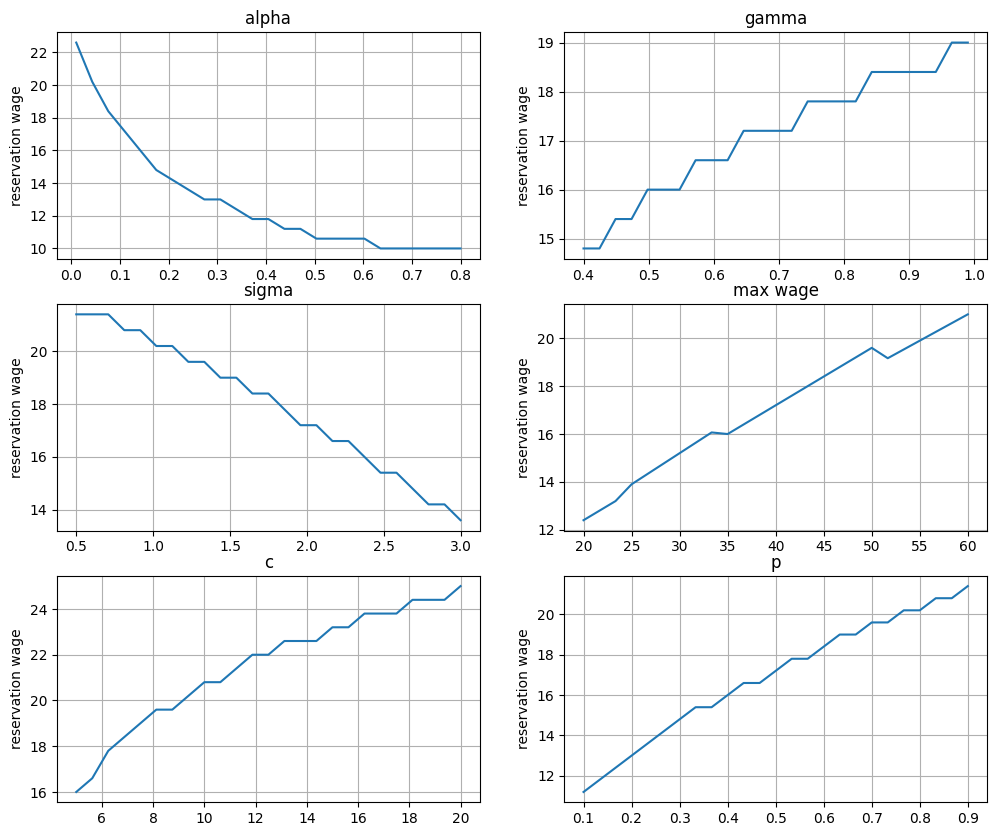

In [50]:
grid_size = 25

α_vals = np.linspace(0.01, 0.8, grid_size)
γ_vals = np.linspace(0.4, 0.99, grid_size)
σ_vals = np.linspace(0.5, 3.0, grid_size)
wmax_vals = np.linspace(20, 60, grid_size)
c_vals = np.linspace(5, 20, grid_size)
p_vals = np.linspace(0.1, 0.9, grid_size)

# your code here

vals_matrix = np.stack((α_vals, γ_vals, σ_vals, wmax_vals, c_vals, p_vals), axis=0)

res_wages1 = []
for i, alpha in enumerate(α_vals):
    mcm = McCallModel(alpha=alpha)
    w_bar = compute_reservation_wage(mcm)
    res_wages1.append(w_bar)

res_wages2 = []
for i, gamma in enumerate(γ_vals):
    mcm = McCallModel(gamma=gamma)
    w_bar = compute_reservation_wage(mcm)
    res_wages2.append(w_bar)

res_wages3 = []
for i, sigma in enumerate(σ_vals):
    mcm = McCallModel(sigma=sigma)
    w_bar = compute_reservation_wage(mcm)
    res_wages3.append(w_bar)

res_wages4 = []
for i, wmax in enumerate(wmax_vals):
    w_default = np.linspace(10, wmax, num=n+1)
    dist = binom(n, p)
    q_default = np.array([dist.pmf(i) for i in range(n+1)])
    mcm = McCallModel(w=w_default)
    w_bar = compute_reservation_wage(mcm)
    res_wages4.append(w_bar)

w_default = np.linspace(10, 40, num=n+1)
dist = binom(n, p)
q_default = np.array([dist.pmf(i) for i in range(n+1)])

res_wages5 = []
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    w_bar = compute_reservation_wage(mcm)
    res_wages5.append(w_bar)

res_wages6 = []
for i, p in enumerate(p_vals):
    dist = binom(n, p)
    q_default = np.array([dist.pmf(i) for i in range(n+1)])
    mcm = McCallModel(q=q_default)
    w_bar = compute_reservation_wage(mcm)
    res_wages6.append(w_bar)

idx = range(6)
plots = [res_wages1, res_wages2, res_wages3, res_wages4, res_wages5, res_wages6]
titles = ['alpha', 'gamma', 'sigma', 'max wage', 'c', 'p']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, id, plot, title in zip(axes.flatten(), idx, plots, titles):
    ax.plot(vals_matrix[id][:], np.array(plot))
    ax.set_ylabel("reservation wage")
    ax.set_title(title)
    ax.grid()

plt.show()    

### Q.1-8: Unemployment Rate in the Steady State

Show how the steady state unemployment rates change as the model parameters change. 

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

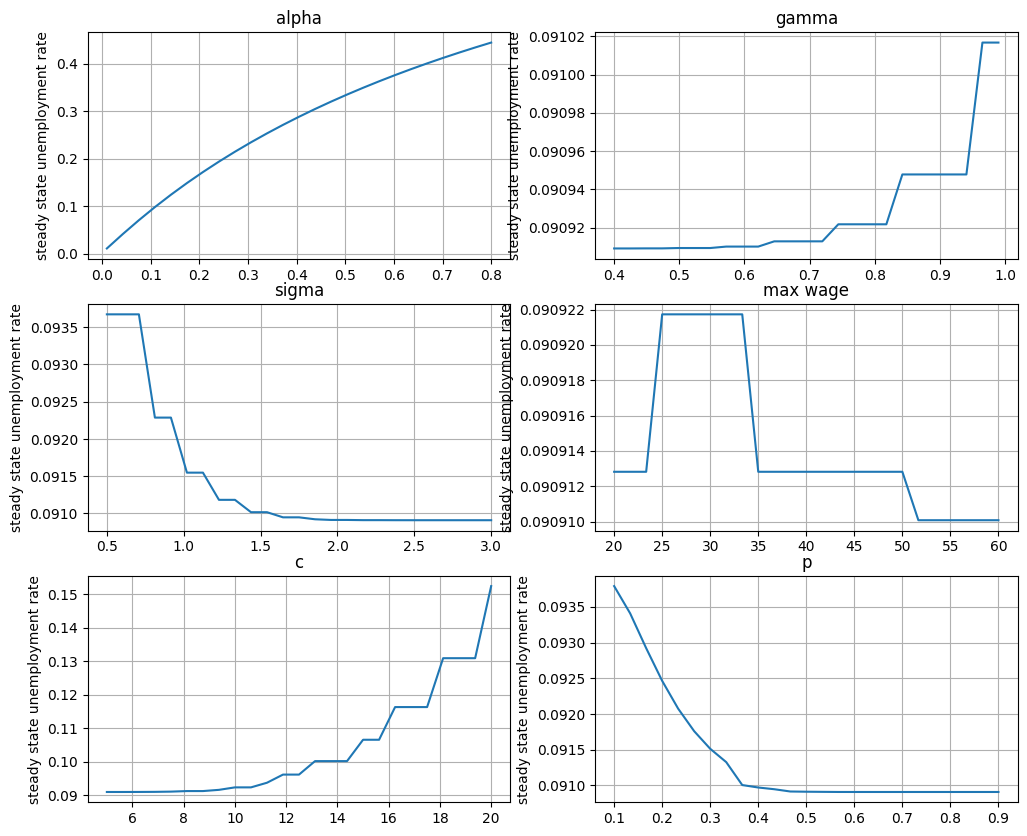

In [51]:
# your code here

vals_matrix = np.stack((α_vals, γ_vals, σ_vals, wmax_vals, c_vals, p_vals), axis=0)

unem_rates1 = []
for i, alpha in enumerate(α_vals):
    mcm = McCallModel(alpha=alpha)
    unem_rate = steady_state_unemployment(mcm)
    unem_rates1.append(unem_rate)

unem_rates2 = []
for i, gamma in enumerate(γ_vals):
    mcm = McCallModel(gamma=gamma)
    unem_rate = steady_state_unemployment(mcm)
    unem_rates2.append(unem_rate)

unem_rates3 = []
for i, sigma in enumerate(σ_vals):
    mcm = McCallModel(sigma=sigma)
    unem_rate = steady_state_unemployment(mcm)
    unem_rates3.append(unem_rate)

unem_rates4 = []
for i, wmax in enumerate(wmax_vals):
    w_default = np.linspace(10, wmax, num=n+1)
    dist = binom(n, p)
    q_default = np.array([dist.pmf(i) for i in range(n+1)])
    mcm = McCallModel(w=w_default)
    unem_rate = steady_state_unemployment(mcm)
    unem_rates4.append(unem_rate)

w_default = np.linspace(10, 40, num=n+1)
dist = binom(n, p)
q_default = np.array([dist.pmf(i) for i in range(n+1)])

unem_rates5 = []
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    unem_rate = steady_state_unemployment(mcm)
    unem_rates5.append(unem_rate)

unem_rates6 = []
for i, p in enumerate(p_vals):
    dist = binom(n, p)
    q_default = np.array([dist.pmf(i) for i in range(n+1)])
    mcm = McCallModel(q=q_default)
    unem_rate = steady_state_unemployment(mcm)
    unem_rates6.append(unem_rate)

idx = range(6)
plots = [unem_rates1, unem_rates2, unem_rates3, unem_rates4, unem_rates5, unem_rates6]
titles = ['alpha', 'gamma', 'sigma', 'max wage', 'c', 'p']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, id, plot, title in zip(axes.flatten(), idx, plots, titles):
    ax.plot(vals_matrix[id][:], np.array(plot))
    ax.set_ylabel("steady state unemployment rate")
    ax.set_title(title)
    ax.grid()

plt.show()

### Q.1-9: Average Unemployment Duration

Show how the average unemployment durations change as the model parameters change. 

- Use the values for parameters as in Q.1-7.
- compute steady state unemployment rates and plot the results

4번째 과제의 1-9번 문제에서 1-8과 동일하게 steady state의 plot을 구하라고 되어 있는데 이게 아니라 1-6에서 정의하신 average unemployment rate의 plot을 그리라는 것이 맞습니다!

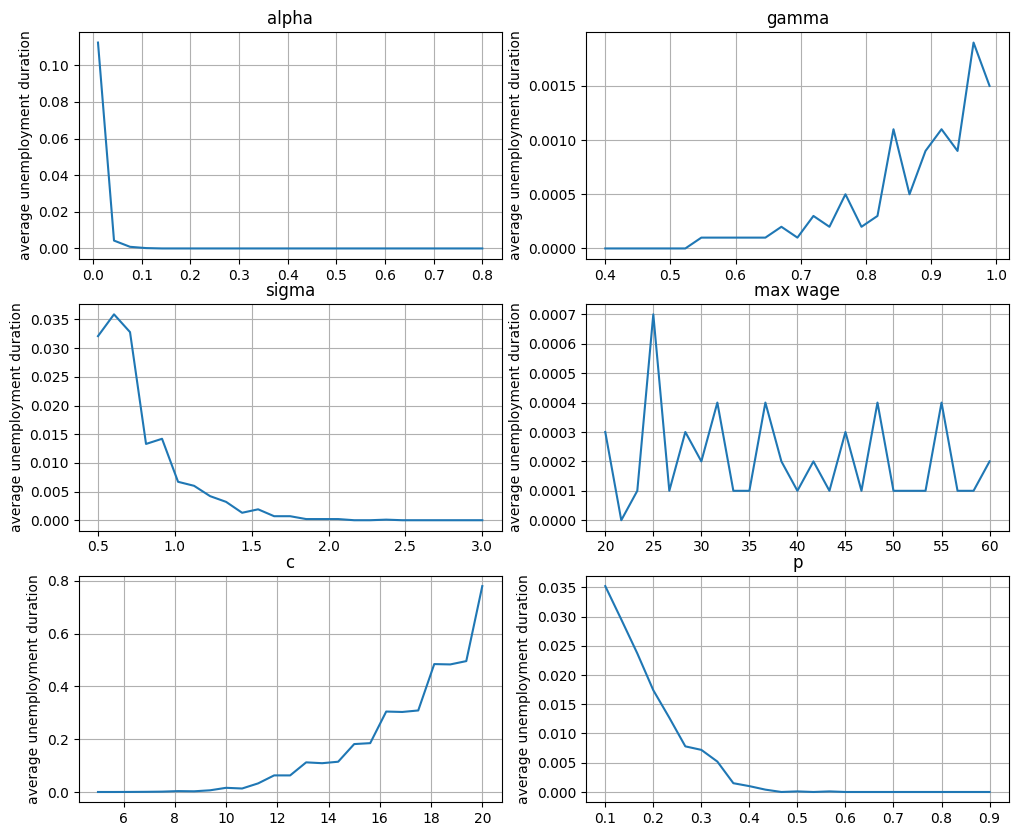

In [52]:
# your code here

# your code here

vals_matrix = np.stack((α_vals, γ_vals, σ_vals, wmax_vals, c_vals, p_vals), axis=0)

unem_durs1 = []
for i, alpha in enumerate(α_vals):
    mcm = McCallModel(alpha=alpha)
    unem_dur = compute_average_unemployment_duration(mcm)
    unem_durs1.append(unem_dur)

unem_durs2 = []
for i, gamma in enumerate(γ_vals):
    mcm = McCallModel(gamma=gamma)
    unem_dur = compute_average_unemployment_duration(mcm)
    unem_durs2.append(unem_dur)

unem_durs3 = []
for i, sigma in enumerate(σ_vals):
    mcm = McCallModel(sigma=sigma)
    unem_dur = compute_average_unemployment_duration(mcm)
    unem_durs3.append(unem_dur)

unem_durs4 = []
for i, wmax in enumerate(wmax_vals):
    w_default = np.linspace(10, wmax, num=n+1)
    dist = binom(n, p)
    q_default = np.array([dist.pmf(i) for i in range(n+1)])
    mcm = McCallModel(w=w_default)
    unem_dur = compute_average_unemployment_duration(mcm)
    unem_durs4.append(unem_dur)

w_default = np.linspace(10, 40, num=n+1)
dist = binom(n, p)
q_default = np.array([dist.pmf(i) for i in range(n+1)])

unem_durs5 = []
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c)
    unem_dur = compute_average_unemployment_duration(mcm)
    unem_durs5.append(unem_dur)

unem_durs6 = []
for i, p in enumerate(p_vals):
    dist = binom(n, p)
    q_default = np.array([dist.pmf(i) for i in range(n+1)])
    mcm = McCallModel(q=q_default)
    unem_dur = compute_average_unemployment_duration(mcm)
    unem_durs6.append(unem_dur)

idx = range(6)
plots = [unem_durs1, unem_durs2, unem_durs3, unem_durs4, unem_durs5, unem_durs6]
titles = ['alpha', 'gamma', 'sigma', 'max wage', 'c', 'p']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, id, plot, title in zip(axes.flatten(), idx, plots, titles):
    ax.plot(vals_matrix[id][:], np.array(plot))
    ax.set_ylabel("average unemployment duration")
    ax.set_title(title)
    ax.grid()

plt.show()

In [ ]:
# binomial distribution은 tail이 작기 때문에 reservation wage보다 작은 wage가 나올 확률이 너무 작아서 duration이 0에 가까움. 이 때문에 max wage에 따른 duration 결과는 편차가 크다.

## Question 2: Continuous and Correlated Wage Offers



### The model

Each period, an employed worker faces a probability $\alpha$ of getting laid off and becoming unemployed. If she survives the exogenous job separation, her wage changes according to a stochastic process of which transition probability distribution is given as $Q(w,w')=\mathrm{P}(w_{t+1}\le w'|w_t = w)$. Observing the wage change, an employed worker has two options:
1. Continues to work at the new wage $w'$: Stay employed
1. Quit the current job and search for a new job: Become unemployed.

For simplicity, assume that an unemployed worker is given UI benefits in the amount of $c$ and receives the wage offer $ \tilde{w} = \displaystyle{\int} w\, d\tilde{Q}(w) $ with a probability $0 < \gamma < 1$, where $\tilde{Q}(w')$ is the marginal distribution associated with $Q(\cdot, w')$. Since no other wage offers will be given, an nemployed worker immediately accepts the wage offer $ \tilde{w} $ once receving it and becomes employed. 

The value of being employed at wage $w$ and the value of being unemployed can be written as follow, respectively:  
<a id='value_V2'></a>
$$
V(w) = u(w) + \beta \Big[ (1-\alpha) \int \max\left\{V(w'), U\right\} q(w,w') dw' + \alpha U \Big] \tag{3}
$$

and

<a id='value_U2'></a>
$$
U = u(c) + \beta \left[(1-\gamma) U + \gamma V(\tilde{w}) \right] \tag{4}
$$

This setup is basically the same optimal stopping time problem. However it is now an **employed** worker's decision of quitting the current job instead of an unemployed worker's decision of taking a new job.

### Q.2-1: Define the class that describes the model economy

Write the class **QuitModel** assuming that wages follow the following AR(1) process: 

$$
\log{w_{t+1}} = \mu + \rho \log{w_t} + 
\epsilon_{t+1}, \qquad \epsilon_{t+1}\sim N(0,s)
$$. 

The contents of the class are similar to those in the class **McCallModel** in Q.1-2. 

- specify types of the variables that are used in the class in `quit_data`
- a function `__init__`: sets the default values for the data.
    - $\alpha = 0.1$: job separation rate
    - $\beta = 0.98$: discount factor
    - $\gamma = 0.7$: offer arrival rate
    - $\mu = 0$: drift term in AR(1) process of wages
    - $\rho = 0.9$: persistence of AR(1) process of wages
    - $s = 0.1$: variance of innovation in AR(1) process of wages
    - $\sigma = 2$: CRRA parameter
    - $c = 6$: unemployment compensation
    - grid_size = 100: length of wage grid vector
    - mc_size = 1,000: Monte Carlo draws for integration
- a function `u`: computes CRRA utility with parameter $\sigma$
- a function `update`: take V and U in the current as inputs and updates them according to equation (3) and (4) 
- jit-compile the class with `@jitclass`


In [53]:
# your code here

quit_data = [
    ('alpha', float64),
    ('beta', float64),
    ('gamma', float64),
    ('mu', float64),
    ('rho', float64),
    ('s', float64),
    ('sigma', float64),
    ('c', float64),
    ('logw_grid', float64[:]),
    ('e_draws', float64[:])]

@jitclass(quit_data)
class QuitModel:

    def __init__(self, alpha=0.1, beta=0.98, gamma=0.7, mu=0.0, rho=0.9, s=0.1, sigma=2.0, c=6.0, grid_size=100, mc_size=1000):
        self.alpha, self.beta, self.gamma, self.mu, self.rho, self.s, self.sigma, self.c = alpha, beta, gamma, mu, rho, s, sigma, c
        
        logw_mean = mu / (1 - rho)
        logw_sd = np.sqrt(np.sqrt(s) / (1 - rho**2))
        k = 3
        a, b = logw_mean - k * logw_sd, logw_mean + k * logw_sd
        self.logw_grid = np.linspace(a, b, grid_size)

        np.random.seed(42)
        self.e_draws = np.sqrt(s) * np.random.randn(mc_size)

    def u(self, x):
        return (x ** (1 - self.sigma) - 1) / (1 - self.sigma)
    
    def find_index(self, x):
        index = - np.inf
        logw_grid = self.logw_grid
        for i, logw in enumerate(logw_grid):
            if logw >= x:
                index = i
                break
        return i

    def update(self, V, U):
        alpha, beta, gamma, mu, rho, s, sigma, c = self.alpha, self.beta, self.gamma, self.mu, self.rho, self.s, self.sigma, self.c
        u = self.u
        logw_grid = self.logw_grid
        e_draws = self.e_draws

        V_new = np.empty_like(V)
        U_new = np.empty_like(U)
    
        for i, logw1 in enumerate(logw_grid):
            expectation = 0.0
            for e in e_draws:
                logw_prime = np.exp(mu + rho * logw1 + e)
                expectation += max(V[self.find_index(logw_prime)], U)
            expectation = expectation / len(e_draws)

            V_new[i] = u(np.exp(logw1)) + beta * ((1 - alpha) * expectation + alpha * U)

        logw_mean = mu / (1 - rho)

        U_new = u(c) + beta * ((1 - gamma) * U + gamma * V[self.find_index(logw_mean)])

        return V_new, U_new

### Q.2-2: Solve Value Functions through Iteration

- Write a function `solve_model` that iterates the value functions V and U until they converge to their fixed points.
- jit-compile the function with `@njit`- Create an instance `qm` of the class `QuitModel` with the default values.
- solve for the fixed points of V and U.
- plot the converged V and U.


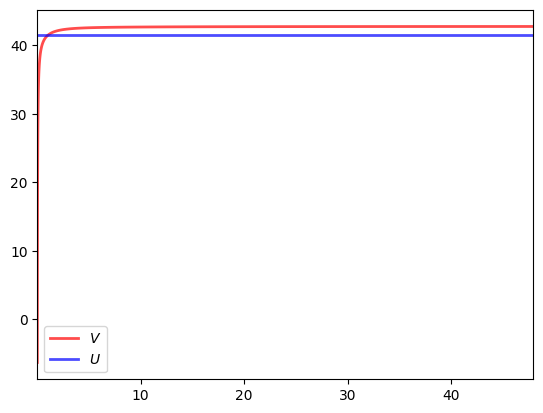

In [54]:
# your code here

@njit
def solve_model(qm, tol=1e-5, max_iter=2000):

    V = np.ones_like(qm.logw_grid)
    U = 1
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        V_new, U_new = qm.update(V, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V = V_new
        U = U_new
        i += 1

    return V, U

qm = QuitModel()
V, U = solve_model(qm)

fig, ax = plt.subplots()

ax.plot(np.exp(qm.logw_grid), V, 'red', lw=2, alpha=0.7, label='$V$')
ax.plot(np.exp(qm.logw_grid), [U] * len(qm.logw_grid), 'blue', lw=2, alpha=0.7, label='$U$')
ax.set_xlim(min(np.exp(qm.logw_grid)), max(np.exp(qm.logw_grid)))
ax.legend()

plt.show()

### Q.2-3: Reservation Wage

- Write a function `compute_reservation_wage` to compute the reservation wage for the model economy using `brentq` from `quantecon.optimize`.
- jit-compile the class with `@njit`
- execute the function to show the reservation wage. 

In [55]:
pip install interpolation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1


In [56]:
# your code here

from interpolation import interp

def compute_reservation_wage(qm):

    V, U = solve_model(qm)
    w_grid = np.exp(qm.logw_grid)
    
    @njit
    def V_U(x):
        return interp(w_grid, V-U, x)

    w_bar = brentq(V_U, 1e-8, 50).root

    return w_bar

compute_reservation_wage(qm)

1.0448291761120745

### Q.2-4: Comparative Statics: Reservation Wage

Show how reservation wages change as the model parameters change. 

- Use the values for parameters below.
- compute reservation wages and plot the results

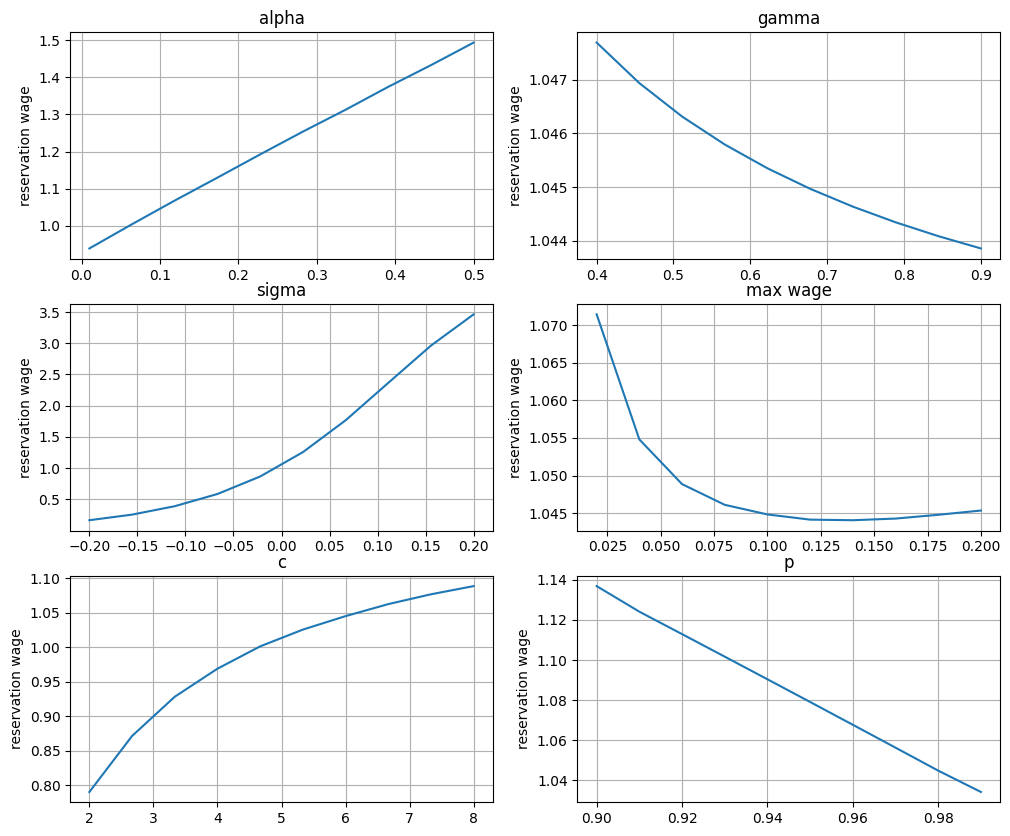

In [57]:
grid_size = 10

α_vals = np.linspace(0.01, 0.5, grid_size)
γ_vals = np.linspace(0.4, 0.9, grid_size)
μ_vals = np.linspace(-0.2, 0.2, grid_size)
s_vals = np.linspace(0.02, 0.2, grid_size)
c_vals = np.linspace(2, 8, grid_size)
β_vals = np.linspace(0.9, 0.99, grid_size)


# your code here


vals_matrix = np.stack((α_vals, γ_vals, μ_vals, s_vals, c_vals, β_vals), axis=0)

res_wages1 = []
for i, alpha in enumerate(α_vals):
    qm = QuitModel(alpha=alpha)
    w_bar = compute_reservation_wage(qm)
    res_wages1.append(w_bar)

res_wages2 = []
for i, gamma in enumerate(γ_vals):
    qm = QuitModel(gamma=gamma)
    w_bar = compute_reservation_wage(qm)
    res_wages2.append(w_bar)

res_wages3 = []
for i, mu in enumerate(μ_vals):
    qm = QuitModel(mu=mu)
    w_bar = compute_reservation_wage(qm)
    res_wages3.append(w_bar)

res_wages4 = []
for i, s in enumerate(s_vals):
    qm = QuitModel(s=s)
    w_bar = compute_reservation_wage(qm)
    res_wages4.append(w_bar)

res_wages5 = []
for i, c in enumerate(c_vals):
    qm = QuitModel(c=c)
    w_bar = compute_reservation_wage(qm)
    res_wages5.append(w_bar)

res_wages6 = []
for i, beta in enumerate(β_vals):
    qm = QuitModel(beta=beta)
    w_bar = compute_reservation_wage(qm)
    res_wages6.append(w_bar)

idx = range(6)
plots = [res_wages1, res_wages2, res_wages3, res_wages4, res_wages5, res_wages6]
titles = ['alpha', 'gamma', 'sigma', 'max wage', 'c', 'p']

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for ax, id, plot, title in zip(axes.flatten(), idx, plots, titles):
    ax.plot(vals_matrix[id][:], np.array(plot))
    ax.set_ylabel("reservation wage")
    ax.set_title(title)
    ax.grid()

plt.show()    